# Value Based Methods


## Stabilizing Deep Reinforcement Learning

The Deep Q-Learning algorithm represents the optimal action-value function $q^*$ as a neural network (instead of a table).

Unfortunately, reinforcement learning is [notoriously unstable](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.73.3097&rep=rep1&type=pdf) when neural networks are used to represent the action values. The Deep Q-Learning algorithm addresses these instabilities by using two key features:
  1. **Experience Replay**
  2. **Fixed Q-Targets**

In [ ]:
from IPython.lib.display import YouTubeVideo

In [ ]:
YouTubeVideo('WgiAvr7COR0')

The main ideas of **Deep Q-Network** (**DQN**) are the result of the following two papers:

  1. [Neural fitted Q iteration–first experiences with a data efficient neural reinforcement learning method](http://ml.informatik.uni-freiburg.de/former/_media/publications/rieecml05.pdf), 2005
  2. [Human-level control through deep reinforcement learning](https://www.nature.com/articles/nature14236.pdf), 2015

## Deep Q-Networks

In [ ]:
YouTubeVideo('GgtR_d1OB-M')

- [ ] The Deep Q-Network (DQN) receives the most recent state of the game as input.  After some preprocessing, this is the 84x84x1 (grayscale) game screen.
- [x] In order to capture temporal information, a stack of 4 preprocessed frames are used as the state that is passed to the DQN.
- [ ] The DQN takes a state and action as input, and returns the corresponding predicted action value.
- [x] The DQN takes the state as input, and returns the corresponding predicted action values for each possible game action.
- [ ] The DQN was provided information about the game of pong - before the agent started learning, the researchers wrote helper functions to ensure the agent always keeps the paddle close to the ball.
- [ ] The DQN architecture included a combination of convolutional and recurrent layers.  The CNN component captures spatial information in the state, and the RNN component detects temporal patterns.
- [ ] The DQN architecture is fully convolutional: it has only convolutional layers and no fully-connected layers.
- [x] The DQN architecture is composed of a couple of convolutional layers, followed by a couple of fully connected layers.
- [x] For each Atari game, the DQN was trained from scratch on that game.
- [ ] The DQN was trained on data from the first several games, and then with that knowledge (and no additional training), it could beat the remaining Atari games.

## Experience Replay

In [ ]:
YouTubeVideo('wX_-SZG-YMQ')

When the agent interacts with the environment, the sequence of experience tuples can be highly correlated. The naive Q-learning algorithm that learns from each of these experience tuples in sequential order runs the risk of getting swayed by the effects of this correlation. By instead keeping track of a **replay buffer** and using **experience replay** to sample from the buffer at random, we can prevent action values from oscillating or diverging catastrophically.

The **replay buffer** contains a collection of experience tuples $(S, A, R, S')$. The tuples are gradually added to the buffer as we are interacting with the environment.

The act of sampling a small batch of tuples from the replay buffer in order to learn is known as **experience replay**. In addition to breaking harmful correlations, experience replay allows us to learn more from individual tuples multiple times, recall rare occurrences, and in general make better use of our experience.

## Fixed Q-Targets

In [ ]:
YouTubeVideo('SWpyiEezfp4')

In [ ]:
YouTubeVideo('-PVFBGN_zoM')

In Q-Learning, we update a guess with a guess, and this can potentially lead to harmful correlations. To avoid this, we can update the parameters ww in the network $\hat{q}$ to better approximate the action value corresponding to state $S$ and action $A$ with the following update rule:
$$\Delta w = \alpha \cdot \overbrace{( \underbrace{R + \gamma \max_a\hat{q}(S', a, w^-)}_{\rm {TD~target}} - \underbrace{\hat{q}(S, A, w)}_{\rm {old~value}})}^{\rm {TD~error}} \nabla_w\hat{q}(S, A, w)$$
where $w^-$ are the weights of a separate target network that are not changed during the learning step, and $(S, A, R, S')$ is an experience tuple.

## Deep Q-Learning

In [ ]:
YouTubeVideo('MqTXoCxQ_eY')

## Application of DQN

We'll implement a DQN agent with OpenAI Gym's [LunarLander](https://gym.openai.com/envs/LunarLander-v2/) environment.

### Import the Packages

In [ ]:
import os
import gym
import random
import numpy as np
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
ENVIRONMENT = 'LunarLander-v2'
MODEL_FILE = './models/dqn-lunar-lander.pt'
RANDOM_SEED = 0

### Instantiate the Environment

Initialize the environment in the code cell below.

In [ ]:
env = gym.make(ENVIRONMENT)

env.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

### Hyperparameters for the Model

In [ ]:
BUFFER_SIZE = int(1e5)   # replay buffer size
BATCH_SIZE = 64          # minibatch size
GAMMA = 0.99             # discount factor
LR = 5e-4                # learning rate
TAU = 1e-3               # update interpolation parameter for target network (soft update)
UPDATE_EVERY = 25        # how often to update the target network (hard update)
TRAIN_EVERY = 4          # how often to train the network

### The Deep Q-Network

We've defined a neural network architecture that maps states to action values. It's up to us to define our own deep Q-network!

In [ ]:
class QNetwork(nn.Module):
    '''
    Q-Network Model
    A network that maps state -> action values
    '''
    def __init__(self, state_size, action_size):
        '''Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
        '''
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, state):
        state = F.relu(self.fc1(state))
        state = F.relu(self.fc2(state))
        return self.fc3(state)

### The Experience-Replay Buffer

In [ ]:
class ReplayBuffer:
    '''Fixed-size buffer to store experience tuples'''

    def __init__(self, action_size, buffer_size, batch_size):
        '''Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        '''
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple('Experience', field_names=['state', 'action', 'reward', 'next_state', 'done'])
    
    def add(self, state, action, reward, next_state, done):
        '''Add a new experience to memory'''
        experience = self.experience(state, action, reward, next_state, done)
        self.memory.append(experience)
    
    def sample(self):
        '''Randomly sample a batch of experiences from memory'''
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        '''Return the current size of internal memory'''
        return len(self.memory)

### The Deep Q-Learning Agent

The `learn` method in the `Agent` class in  does the actual learning. It uses sampled batch of experience tuples.

In [ ]:
class Agent():
    '''Interacts with and learns from the environment'''

    def __init__(self, state_size, action_size):
        '''Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
        '''
        self.state_size = state_size
        self.action_size = action_size

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE)
        
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
        self.target_t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % TRAIN_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.memory.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.0):
        '''Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        '''
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        '''Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        '''
        states, actions, rewards, next_states, dones = experiences

        # Compute and minimize the loss
        states, actions, rewards, next_states = states.to(device), actions.to(device), rewards.to(device), next_states.to(device)

        
#         https://stackoverflow.com/questions/56816241/difference-between-detach-and-with-torch-nograd-in-pytorch
#         with torch.no_grad():
#             Q_targets_next = self.qnetwork_target(next_states).max(1)[0].unsqueeze(1)
#             Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        Q_expected = self.qnetwork_local(states).gather(1, actions)
        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Soft update target network
        self.soft_update(self.qnetwork_target, self.qnetwork_local, TAU)
        
#         # Hard update target network
#         self.target_t_step = (self.target_t_step + 1) % UPDATE_EVERY
#         if self.target_t_step == 0:
#             self.hard_update(self.qnetwork_target, self.qnetwork_local)


    def soft_update(self, target_model, local_model, tau):
        '''Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            target_model (PyTorch model): weights will be copied to
            local_model (PyTorch model): weights will be copied from
            tau (float): interpolation parameter 
        '''
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
    
    def hard_update(self, target_model, local_model):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(local_param.data)

### Watch an Untrained Agent in Action

In [ ]:
agent = Agent(state_size=8, action_size=4)
state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
for j in range(200):
    action = agent.act(state)
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    state, reward, done, _ = env.step(action)
    if done:
        break

### Train the Agent with DQN

Run the code cell below to train the agent from scratch. Try different values of the parameters in the function, to try to get better performance!

In [ ]:
LOG_EVERY = 100       # log scores after this many episodes
SAVE_EVERY = 200      # save the model after this many episodes
TARGET_SCORE = 300.0  # score to solve the environment

In [ ]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    '''Deep Q-Learning.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    '''
    env = gym.make(ENVIRONMENT)
    agent = Agent(state_size=8, action_size=4)

    solved = False                                                 # flag to test whether the env is already solved
    start_episode = 1
    scores_window = deque(maxlen=100)                              # last 100 scores
    eps = eps_start                                                # initialize epsilon
    scores = []                                                    # list containing scores from each episode

    if os.path.isfile(MODEL_FILE):                                 # continue training from last checkpoint
        # load training checkpoints from file
        map_location = (lambda storage, loc: storage.cuda()) if torch.cuda.is_available() else 'cpu'
        checkpoint = torch.load(MODEL_FILE, map_location=map_location)        

        agent.qnetwork_local.load_state_dict(checkpoint['local_model_state_dict'])
        agent.qnetwork_target.load_state_dict(checkpoint['target_model_state_dict'])
        agent.optimizer.load_state_dict(checkpoint['optimizer_state_dict']) 

        eps = checkpoint['epsilon']
        solved = checkpoint['solved']
        scores = checkpoint['scores']
        start_episode = checkpoint['episode']

    if solved:
        return scores

    agent.qnetwork_local.train()
    scores_window.extend(scores)

    try:
        for i_episode in range(start_episode, start_episode + n_episodes):
            state = env.reset()
            score = 0
            for t in range(max_t):
                action = agent.act(state, eps)
                next_state, reward, done, _ = env.step(action)
                agent.step(state, action, reward, next_state, done)
                state = next_state
                score += reward
                if done:
                    break
            scores_window.append(score)                                # save most recent score
            scores.append(score)                                       # save most recent score
            eps = max(eps_end, eps_decay*eps)                          # decrease epsilon

            # log progress
            print('\rEpisode {:04d}\tAverage Score: {:.2f}\tCurrent Score: {:.2f}'.format(i_episode, np.mean(scores_window), score), end='')
            if i_episode % LOG_EVERY == 0:
                print('\r{}'.format(' ' * 120), end='')
                print('\rEpisode {:04d}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            if (
                (i_episode == start_episode + n_episodes - 1) or
                (i_episode % SAVE_EVERY == 0) or
                np.mean(scores_window) >= TARGET_SCORE
            ):
                torch.save({
                    'local_model_state_dict': agent.qnetwork_local.state_dict(),
                    'target_model_state_dict': agent.qnetwork_target.state_dict(),
                    'optimizer_state_dict': agent.optimizer.state_dict(),
                    'epsilon': eps,
                    'solved': True if np.mean(scores_window) >= TARGET_SCORE else False,
                    'scores': scores,
                    'episode': i_episode
                }, MODEL_FILE)
                if np.mean(scores_window) >= TARGET_SCORE:
                    print('\nEnvironment solved in {:04d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
                    break
        return scores
    except KeyboardInterrupt:
        print('\nTraining Interrupted')
        return scores

#### The Training Loop

In [ ]:
scores = dqn()

### Plot the Scores

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Watch a Smart Agent in Action

In the next code cell, the trained weights from file are loaded to watch a smart agent!

In [ ]:
env = gym.make(ENVIRONMENT)
agent = Agent(state_size=8, action_size=4)

# load the weights from file
map_location = (lambda storage, loc: storage.cuda()) if torch.cuda.is_available() else 'cpu'
checkpoint = torch.load(MODEL_FILE, map_location=map_location)        
agent.qnetwork_local.load_state_dict(checkpoint['local_model_state_dict'])
agent.qnetwork_local.eval()

# simulate the smart agent
for e in range(2):
    state = env.reset()
    img = plt.imshow(env.render(mode='rgb_array'))
    for t in range(1000):
        action = agent.act(state)
        img.set_data(env.render(mode='rgb_array')) 
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        state, reward, done, _ = env.step(action)
        if done:
            break

In [ ]:
env.close()

### Deep Q-Learning Improvements

#### Double DQN

Deep Q-Learning [tends to overestimate](https://www.ri.cmu.edu/pub_files/pub1/thrun_sebastian_1993_1/thrun_sebastian_1993_1.pdf) action values. [Double Q-Learning](https://arxiv.org/abs/1509.06461) has been shown to work well in practice to help with this.

In [ ]:
YouTubeVideo('PGCEMLujiGI')

#### Prioritized Experience Replay

Deep Q-Learning samples experience transitions *uniformly* from a replay memory. [Prioritized experienced replay](https://arxiv.org/abs/1511.05952) is based on the idea that the agent can learn more effectively from some transitions than from others, and the more important transitions should be sampled with higher probability.

[Here](https://github.com/Damcy/prioritized-experience-replay) are two implmentations of Prioritized Experience Replay.

There is another technique of sampling called [Hindsight Experience Replay](https://arxiv.org/abs/1707.01495). 

In [ ]:
YouTubeVideo('cN8z-7Ze9L8')

#### Dueling DQN

Currently, in order to determine which states are (or are not) valuable, we have to estimate the corresponding action values *for each action*. However, by replacing the traditional Deep Q-Network (DQN) architecture with a [dueling architecture](https://arxiv.org/abs/1511.06581), we can assess the value of each state, without having to learn the effect of each action.

In [ ]:
YouTubeVideo('zZeHbPs39Ls')

#### Rainbow

Double DQN (DDQN), Prioritized experience replay, Dueling DQN are not the only extensions to the DQN algorithm! Many more extensions have been proposed, including:

- Learning from [multi-step bootstrap targets](https://arxiv.org/abs/1602.01783) (as in A3C)
- [Distributional DQN](https://arxiv.org/abs/1707.06887)
- [Noisy DQN](https://arxiv.org/abs/1706.10295)

Each of the six extensions address a different issue with the original DQN algorithm.

Researchers at Google DeepMind recently tested the performance of an agent that incorporated all six of these modifications. The corresponding algorithm was termed [Rainbow](https://arxiv.org/abs/1710.02298). It outperforms each of the individual modifications and achieves state-of-the-art performance on Atari 2600 games.

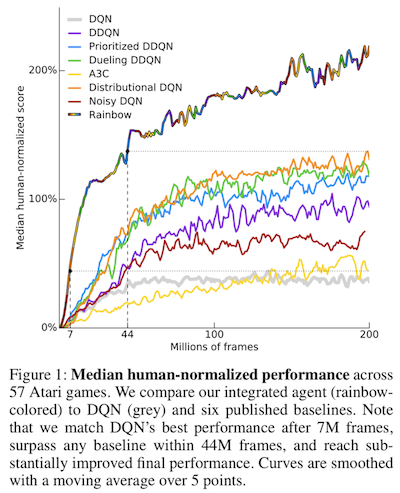

---

Next: [Policy Based Methods](./Policy%20Based%20Methods.ipynb)